In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import matplotlib.pyplot as plt
import cv2

# Paths
DATASET_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation"
IMAGE_DIR = os.path.join(DATASET_PATH, "ISIC2018_Task1-2_Training_Input")
MASK_DIR = os.path.join(DATASET_PATH, "ISIC2018_Task1_Training_GroundTruth")
VALIDATION_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input"
TESTING_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input"
VALIDATION_MASK_PATH = "/kaggle/input/val-mask-truth/ISIC2018_Task1_Validation_GroundTruth"
TESTING_MASK_PATH = "/kaggle/input/test-mast-truth/ISIC2018_Task1_Test_GroundTruth"

# Get image and mask paths
image_paths = sorted(glob.glob(IMAGE_DIR + "/*.jpg"))
mask_paths = sorted(glob.glob(MASK_DIR + "/*.png"))
validation_image_paths = sorted(glob.glob(VALIDATION_PATH + "/*.jpg"))
validation_mask_paths = sorted(glob.glob(VALIDATION_MASK_PATH + "/*.png"))
test_image_paths = sorted(glob.glob(TESTING_PATH + "/*.jpg"))
test_mask_paths = sorted(glob.glob(TESTING_MASK_PATH + "/*.png"))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Dataset Class
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) / 255.0  # Normalize mask

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

# Data Augmentation
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Create Dataset and DataLoader
train_dataset = SkinLesionDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

validation_dataset = SkinLesionDataset(validation_image_paths, validation_mask_paths, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)


test_dataset = SkinLesionDataset(test_image_paths, test_mask_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
# for i in range(len(validation_dataset)):
#     try:
#         image, mask = validation_dataset[i]
#         print(f"Successfully loaded image {i} with shape: {image.shape}, mask shape: {mask.shape}")
#     except Exception as e:
#         print(f"Error loading image {i}: {e}")
#         break

In [5]:

# Kurtosis-guided Statistical Counting Operator (KSCO)
class KSCO(nn.Module):
    def __init__(self, in_channels, levels=256):
        super(KSCO, self).__init__()
        self.levels = levels
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)  # Reduce channels to 1

    def forward(self, x):
        x = self.conv(x)  # Ensure single-channel input
        x_mean = torch.mean(x, dim=(2, 3), keepdim=True)
        x_std = torch.std(x, dim=(2, 3), keepdim=True)
        
        # Clamp x_std to avoid division by zero
        x_std = torch.clamp(x_std, min=1e-6)
        
        kurtosis = torch.mean(((x - x_mean) / x_std) ** 4, dim=(2, 3), keepdim=True)
        
        # Clamp kurtosis to avoid extreme values
        kurtosis = torch.clamp(kurtosis, max=10.0)
        
        quantized_x = torch.floor(((x - x.min()) / (x.max() - x.min())) * self.levels) / self.levels
        return quantized_x * kurtosis

# Statistical Texture Fusion Transformer (STFT)
class STFT(nn.Module):
    def __init__(self, in_channels):
        super(STFT, self).__init__()
        self.ksco = KSCO(in_channels=in_channels)
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels // 2)
        self.conv2 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.gate = nn.Sigmoid()

    def forward(self, x):
        ksco_out = self.ksco(x)
        fusion = self.conv1(x)
        fusion = self.bn1(fusion)
        fusion = self.conv2(fusion)
        fusion = self.bn2(fusion)
        
        # Clamp fusion outputs for stability
        fusion = torch.clamp(fusion, min=-10.0, max=10.0)
        
        return self.gate(fusion) * ksco_out

class STET(nn.Module):
    def __init__(self, in_channels):
        super(STET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels // 2)
        self.conv2 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.dilated_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, dilation=2, padding=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Clamp outputs for stability
        x = torch.clamp(x, min=-10.0, max=10.0)

        return self.dilated_conv(x)


In [6]:
class SkinFormer(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SkinFormer, self).__init__()
        self.encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True, features_only=True)
        
        for param in self.encoder.parameters():
            param.requires_grad = True  # Ensure all layers can train

        self.stft = STFT(1024)
        self.stet = STET(512)
        self.channel_reduction = nn.Conv2d(1024, 512, kernel_size=1)
        self.final_conv = nn.Conv2d(512, out_channels, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        features = self.encoder(x)  # Extract features
    
        f1 = self.stft(features[-1].permute(0, 3, 1, 2))  # (batch, 1024, 7, 7)
        f2 = self.stet(features[-2].permute(0, 3, 1, 2))  # (batch, 512, 14, 14)
    
        # Upsample f1 to match f2's spatial size (14x14)
        f1 = nn.functional.interpolate(f1, size=(14, 14), mode='bilinear', align_corners=True)
        
        # Apply the channel reduction conv layer
        f1 = self.channel_reduction(f1)
    
        output = self.upsample(f1 + f2)  # (batch, 1, 28, 28)
    
        output = nn.functional.interpolate(output, size=(224, 224), mode='bilinear', align_corners=True)
    
        return self.final_conv(output)  # Output is now (batch, 1, 224, 224)



In [7]:
class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DiceFocalLoss, self).__init__()
        self.alpha = alpha

    def forward(self, pred, target):
        # Ensure pred is the same size as target
        pred = nn.functional.interpolate(pred, size=target.shape[2:], mode="bilinear", align_corners=True)

        pred = torch.sigmoid(pred)
        intersection = torch.sum(pred * target)
        dice_loss = 1 - (2. * intersection + 1e-6) / (torch.sum(pred) + torch.sum(target) + 1e-6)

        focal_loss = -target * torch.log(pred + 1e-6) - (1 - target) * torch.log(1 - pred + 1e-6)
        focal_loss = torch.mean(torch.pow(1 - pred, 2.0) * focal_loss)

        return self.alpha * dice_loss + (1 - self.alpha) * focal_loss

In [8]:
# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SkinFormer().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [9]:
# Training Function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1} started")
        
        model.train()
        total_loss = 0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.unsqueeze(1).to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Validation Step
        model.eval()
        val_loss = 0
        
        # Check if validation_loader is not empty
        if len(val_loader) > 0:
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device), masks.unsqueeze(1).to(device).float()
                    outputs = model(images)
                    val_loss += criterion(outputs, masks).item()

            val_losses.append(val_loss / len(val_loader))
            print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
        else:
            val_losses.append(0)  # Append 0 or some default value
            print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, No validation data.")
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")
            print(f"Checkpoint saved at epoch {epoch+1}")
        
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, color='blue', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_losses, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch 1 started
Epoch 1: Train Loss = 0.1682, Val Loss = 0.1588

Epoch 2 started
Epoch 2: Train Loss = 0.1117, Val Loss = 0.1404

Epoch 3 started
Epoch 3: Train Loss = 0.0974, Val Loss = 0.1154

Epoch 4 started
Epoch 4: Train Loss = 0.0834, Val Loss = 0.1811

Epoch 5 started
Epoch 5: Train Loss = 0.0743, Val Loss = 0.1372
Checkpoint saved at epoch 5

Epoch 6 started
Epoch 6: Train Loss = 0.0705, Val Loss = 0.1445

Epoch 7 started
Epoch 7: Train Loss = 0.0657, Val Loss = 0.1251

Epoch 8 started
Epoch 8: Train Loss = 0.0717, Val Loss = 0.1477

Epoch 9 started
Epoch 9: Train Loss = 0.0546, Val Loss = 0.1786

Epoch 10 started
Epoch 10: Train Loss = 0.0505, Val Loss = 0.1847
Checkpoint saved at epoch 10

Epoch 11 started
Epoch 11: Train Loss = 0.0452, Val Loss = 0.1444

Epoch 12 started
Epoch 12: Train Loss = 0.0441, Val Loss = 0.1356

Epoch 13 started
Epoch 13: Train Loss = 0.0429, Val Loss = 0.1723

Epoch 14 started
Epoch 14: Train Loss = 0.0397, Val Loss = 0.1617

Epoch 15 started
Epoch

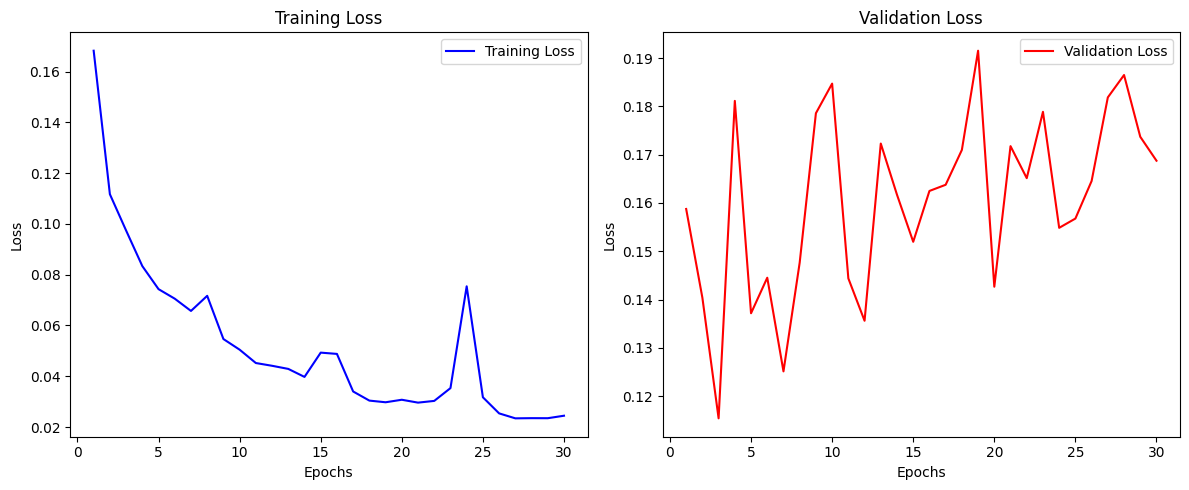

In [10]:
# Train the model
train(model, train_loader, validation_loader, criterion, optimizer)

In [11]:
# Load the checkpoint
checkpoint = torch.load('/kaggle/working/checkpoint_epoch_30.pth', map_location=device, weights_only=True)

# Directly load the state dictionary without needing a key
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [12]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8
            
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [15]:
check_accuracy(test_loader, model, device)

Dice score: 0.8816891655067982


In [45]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Paths for validation images and masks
validation_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input"
val_img = sorted(glob.glob(validation_path + "/*.jpg"))
mask_path = r"/kaggle/input/test-mast-truth/ISIC2018_Task1_Test_GroundTruth"
val_mask = sorted(glob.glob(mask_path + "/*.png"))

val_dataset = SkinLesionDataset(image_paths=validation_path,
                            mask_paths=mask_path,transform=transform)

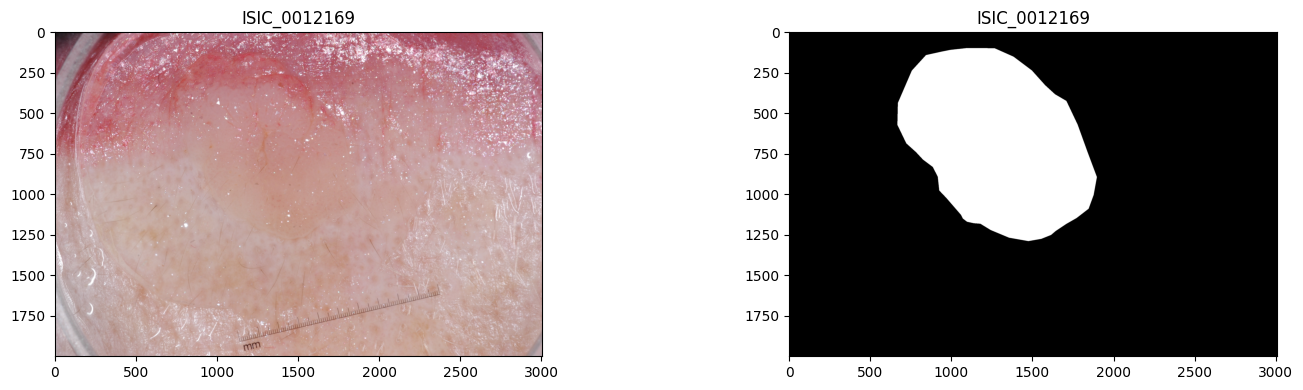

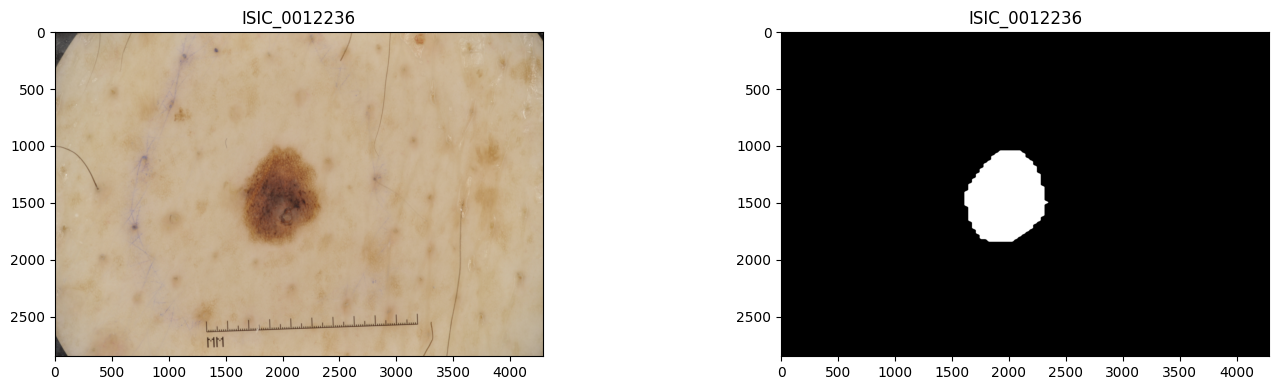

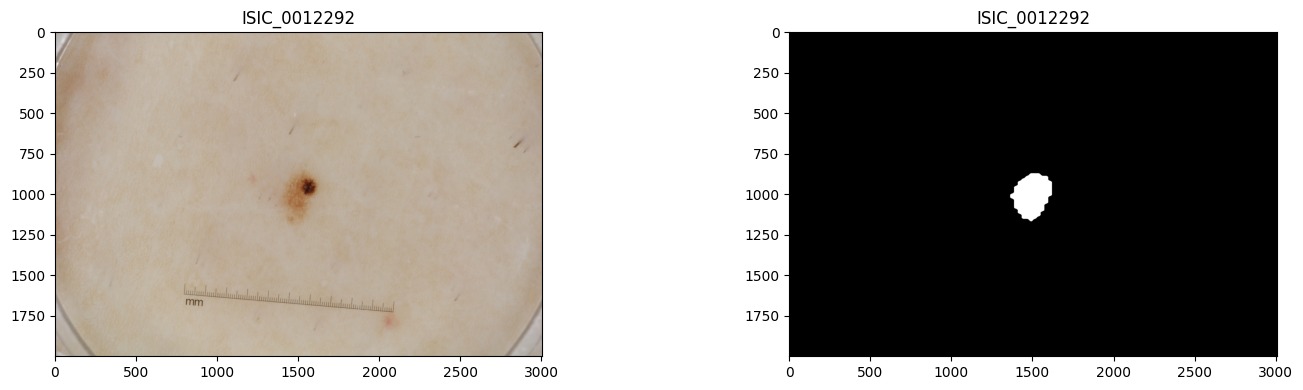

In [46]:
for i in range(3):
    samImg = cv2.imread(val_img[i])
    samMask = cv2.imread(val_mask[i])
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(val_img[i].split('/')[-1].rstrip(".jpg"))
    plt.imshow(cv2.cvtColor(samImg,cv2.COLOR_BGR2RGB))
    
    plt.subplot(1,2,2)
    plt.title(val_mask[i].split('/')[-1].rstrip("_segmentation.png"))
    plt.imshow(samMask)
    plt.tight_layout()
    plt.show()

In [47]:
# Define the transformation (resize, normalization) if needed

def preprocess_image(image_path, size,device):
    # Load image with OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if needed

    # Resize the image if needed
    img_resized = cv2.resize(img, (size, size))

    # Convert image to float and normalize (assuming the model expects 0-1 range)
    img_resized = img_resized / 255.0

    # Convert to torch tensor and move to the specified device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    return img_tensor

In [48]:
# Initialize lists for storing metrics
imgId, dice_scores, iou_scores, sensitivities, specificities = [], [], [], [], []
size = 224

# Loop through validation images and evaluate each one
for i in range(len(val_img)):
    # Preprocess the image
    img_tensor = preprocess_image(val_img[i], size, device)
    with torch.no_grad():
        # Get predicted mask
        generated_mask = model(img_tensor).squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy
    
    # Load and resize true mask for comparison
    true_mask = cv2.imread(val_mask[i], cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (generated_mask.shape[1], generated_mask.shape[0]))

    # Binarize masks for metric calculations
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask > threshold).astype(np.uint8)

    # Calculate metrics (Dice, IoU, Sensitivity, Specificity)
    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))
    dice_scores.append(dice_score)
    
    union = np.sum(true_mask_bin) + np.sum(generated_mask_bin) - intersection
    iou = intersection / union if union != 0 else 0
    iou_scores.append(iou)
    
    true_positive = np.sum((true_mask_bin == 1) & (generated_mask_bin == 1))
    false_negative = np.sum((true_mask_bin == 1) & (generated_mask_bin == 0))
    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    sensitivities.append(sensitivity)
    
    true_negative = np.sum((true_mask_bin == 0) & (generated_mask_bin == 0))
    false_positive = np.sum((true_mask_bin == 0) & (generated_mask_bin == 1))
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    specificities.append(specificity)
    
    # Store image id and scores
    imgId.append(val_img[i].split('/')[-1].rstrip(".jpg"))

In [49]:
# Compile results into a DataFrame
df = pd.DataFrame({
    "img_id": imgId,
    "dice_score": dice_scores,
    "jaccard_index": iou_scores,
    "sensitivity": sensitivities,
    "specificity": specificities
})

In [50]:
print(df)

           img_id  dice_score  jaccard_index  sensitivity  specificity
0    ISIC_0012169    0.147642       0.079705     0.086353     0.982988
1    ISIC_0012236    0.959646       0.922423     0.970375     0.998078
2    ISIC_0012292    0.868365       0.767355     0.925339     0.998170
3    ISIC_0012302    0.923526       0.857918     0.860891     0.999855
4    ISIC_0012337    0.930305       0.869691     0.947424     0.998273
..            ...         ...            ...          ...          ...
995  ISIC_0036343    0.917580       0.847711     1.000000     0.944449
996  ISIC_0036344    0.891703       0.804571     0.997070     0.995015
997  ISIC_0036345    0.938712       0.884503     0.999144     0.730387
998  ISIC_0036346    0.938693       0.884469     0.885593     0.999233
999  ISIC_0036347    0.924036       0.858799     1.000000     0.938680

[1000 rows x 5 columns]


In [30]:
#os.remove("/kaggle/working/checkpoint_epoch_15.pth.tar")

In [51]:
df.to_excel("result_analysis.xlsx")

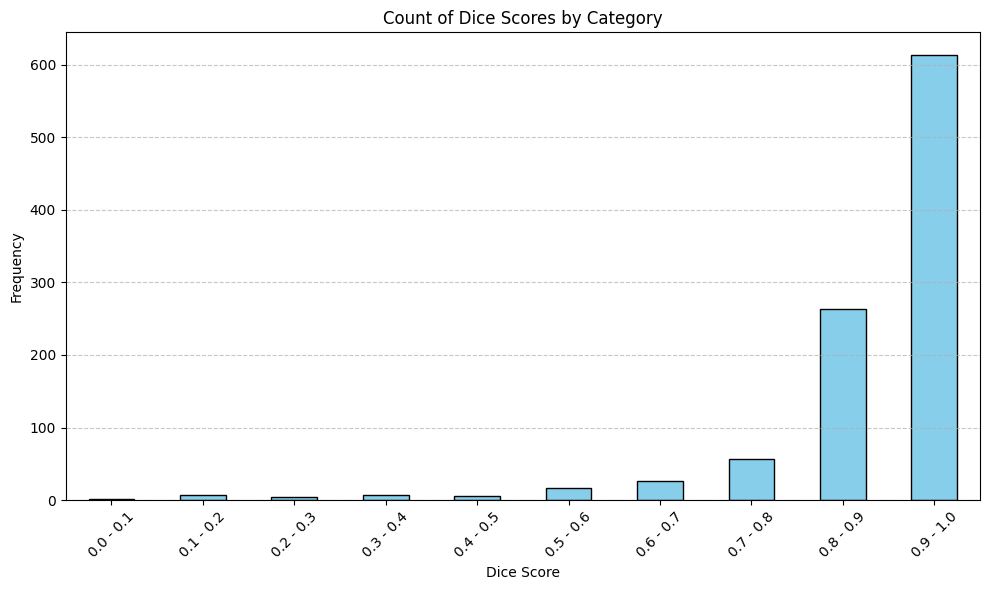

In [52]:
# Plot Dice Score Distribution
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4',
          '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8',
          '0.8 - 0.9', '0.9 - 1.0']

df['Category'] = pd.cut(df['dice_score'].round(2), bins=bins, labels=labels, right=False)
category_counts = df['Category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Dice Scores by Category')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

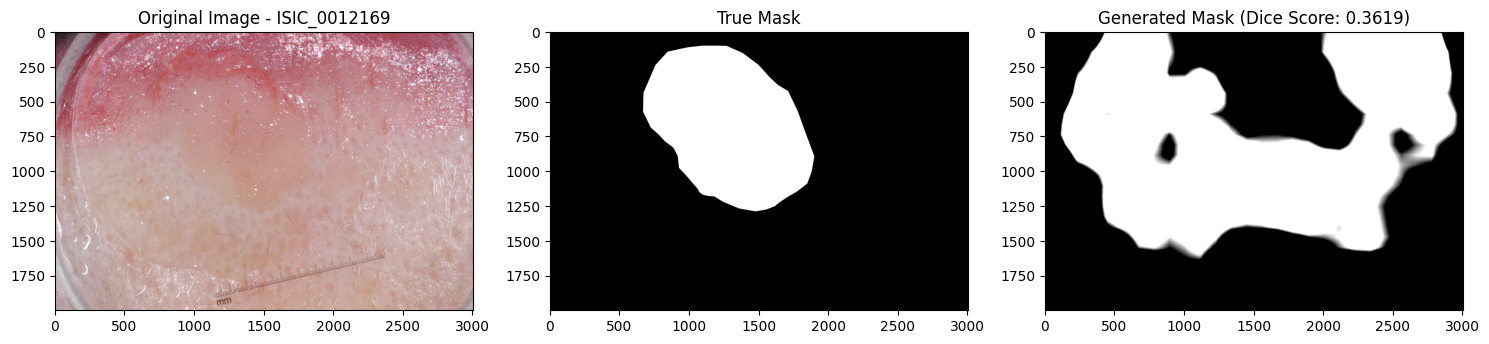

In [54]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def manual_check_single_image(image_idx=0):
    # Load the image path and true mask path
    img_path = val_img[image_idx]
    mask_path = val_mask[image_idx]
    
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (size, size)) / 255.0  # Resize and normalize

    # Load the true mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (size, size))

    # Convert image to tensor and move to the device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # Generate the mask with the model
    with torch.no_grad():
        generated_mask = model(img_tensor).squeeze().cpu().numpy()

    # Resize generated mask back to original image size for visualization
    generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
    true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))

    # Stack the masks for visualization
    true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)
    generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

    # Calculate Dice Score
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask_resized > threshold).astype(np.uint8)
    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))

    # Image ID
    img_id = img_path.split('/')[-1].rstrip(".jpg")

    # Plot original image, true mask, and generated mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title(f'Original Image - {img_id}')
    ax[1].imshow(true_mask_stacked, cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(generated_mask_stacked, cmap='gray')
    ax[2].set_title(f'Generated Mask (Dice Score: {dice_score:.4f})')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Call the function to display the results for a single image
manual_check_single_image(image_idx=0)


In [ ]:

# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from reportlab.lib.pagesizes import letter
# from reportlab.pdfgen import canvas
# import os

# def manual_check_to_pdf(start_idx=0, num_images=100, pdf_filename="image_report.pdf"):
#     pdf = canvas.Canvas(pdf_filename, pagesize=letter)
#     width, height = letter
#     y_position = height - 40  # Initial position from top of the page
    
#     for ind in range(start_idx, start_idx + num_images):
#         # Load the image path and true mask path based on the index
#         img_path = val_img[ind]
#         mask_path = val_mask[ind]
        
#         # Load and preprocess the image
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         img_resized = cv2.resize(img, (size, size)) / 255.0  # Resize and normalize to 0-1
        
#         # Load the true mask
#         true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         true_mask_resized = cv2.resize(true_mask, (size, size))
        
#         # Convert image to tensor and move to the device
#         img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
        
#         # Generate the mask with the model
#         with torch.no_grad():
#             generated_mask = model(img_tensor).squeeze().cpu().numpy()

#         # Resize generated mask back to original image size for visualization
#         generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
#         true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))

#         # Stack the masks for visualization
#         true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)
#         generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

#         # Calculate Dice Score
#         threshold = 0.5
#         true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
#         generated_mask_bin = (generated_mask_resized > threshold).astype(np.uint8)

#         intersection = np.sum(true_mask_bin * generated_mask_bin)
#         dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))

#         # Image ID
#         img_id = img_path.split('/')[-1].rstrip(".jpg")

#         # Plot original image, true mask, and generated mask
#         fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#         ax[0].imshow(img)
#         ax[0].set_title(f'Original Image - {img_id}')
#         ax[1].imshow(true_mask_stacked, cmap='gray')
#         ax[1].set_title('True Mask')
#         ax[2].imshow(generated_mask_stacked, cmap='gray')
#         ax[2].set_title('Generated Mask')
#         plt.tight_layout()

#         # Save the plot as an image
#         plot_filename = f"temp_plot_{img_id}.png"
#         plt.savefig(plot_filename, bbox_inches='tight', dpi=150)
#         plt.close()

#         # Add the plot image to the PDF
#         if y_position - 150 < 40:  # Check if there's enough space for the next image
#             pdf.showPage()  # Add a new page
#             y_position = height - 40  # Reset the Y position
        
#         pdf.drawImage(plot_filename, 40, y_position - 150, width=500, height=150)
        
#         # Add the Dice Score text below the image
#         pdf.setFont("Helvetica", 10)
#         y_position -= 160  # Move down to leave space for the text
#         pdf.drawString(40, y_position, f"Image ID: {img_id}")
#         pdf.drawString(40, y_position - 20, f"Dice Score: {dice_score:.4f}")
        
#         # Move Y position down for next entry
#         y_position -= 40
        
#         # Clean up by deleting the temporary image
#         os.remove(plot_filename)

#     # Save the final PDF
#     pdf.save()
#     print(f"PDF saved as {pdf_filename}")

# # Call the function to generate the PDF report for 100 images starting from index 0
# manual_check_to_pdf(start_idx=0, num_images=100, pdf_filename="image_report.pdf")


In [23]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
